In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans             
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

file_path = r'C:\Users\Luca\Documents\Fatesg-IA-2\Big-Data\Raspagem de Dados\data\raw\dataset_crawler-google-places_2025-11-10_12-46-55-562.json'
df = pd.read_json(file_path)

df['reviewsCount_log'] = np.log1p(df['reviewsCount'])
dummies = pd.get_dummies(df['categoryName'], prefix='cat')
df = pd.concat([df, dummies], axis=1)

colunas_para_dropar = [
    'title', 'street', 'city', 'state', 'countryCode', 'phone', 'website', 'zip', 'categoryName', 'reviewsCount', 'url', 'Y_class' 
]
X = df.drop(colunas_para_dropar, axis=1, errors='ignore').drop('totalScore', axis=1)

print(f"Features (X) para Clusterização: {X.columns.tolist()}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nDados escalonados com sucesso (Média 0, DP 1). Prontos para K-Means.")

Features (X) para Clusterização: ['reviewsCount_log', 'cat_Empório gourmet', 'cat_Lanchonete', 'cat_Restaurante', 'cat_Restaurante Mineiro', 'cat_Restaurante brasileiro', 'cat_Restaurante fast-food', 'cat_Restaurante italiano', 'cat_Restaurante self-service']

Dados escalonados com sucesso (Média 0, DP 1). Prontos para K-Means.


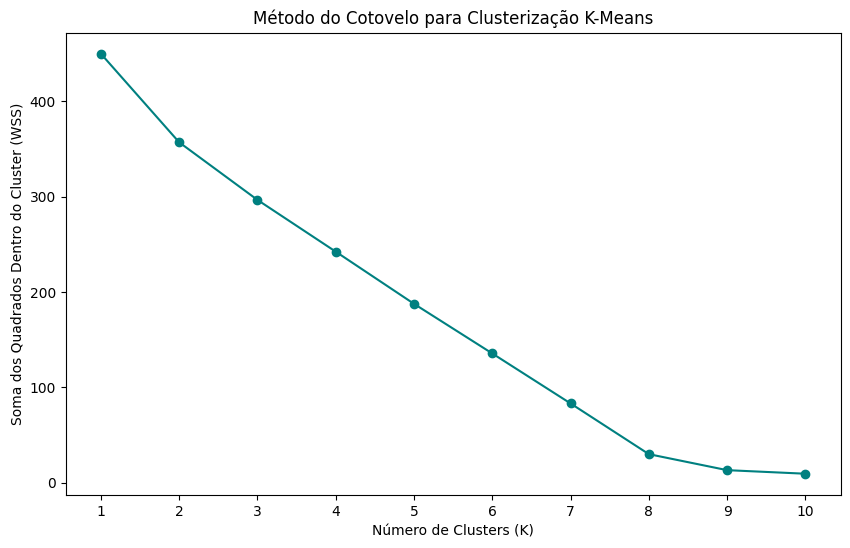

In [ ]:
wss_list = []

K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wss_list.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, wss_list, marker='o', linestyle='-', color='teal')
plt.title('Método do Cotovelo para Clusterização K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Soma dos Quadrados Dentro do Cluster (WSS)')
plt.xticks(K_range)
plt.show()

In [ ]:
optimal_k = 3 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

df['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"\nClusterização K-Means finalizada com K={optimal_k}. Distribuição dos Clusters:")
print(df['Cluster'].value_counts())

cluster_profiles = df.groupby('Cluster')[['totalScore', 'reviewsCount_log', 'categoryName']].agg({
    'totalScore': 'mean',
    'reviewsCount_log': 'mean',
    'categoryName': lambda x: x.mode()[0] 
}).reset_index()

print("\n=== PERFIL MÉDIO DOS CLUSTERS ===")
print(cluster_profiles)


Clusterização K-Means finalizada com K=3. Distribuição dos Clusters:
Cluster
0    28
1    19
2     3
Name: count, dtype: int64

=== PERFIL MÉDIO DOS CLUSTERS ===
   Cluster  totalScore  reviewsCount_log              categoryName
0        0    4.428571          4.318369               Restaurante
1        1    4.431579          6.266766  Restaurante self-service
2        2    4.533333          3.318693                Lanchonete


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['Principal_Componente_1', 'Principal_Componente_2'])
pca_df['Cluster'] = df['Cluster'] 

print("\nPCA concluído. Dados reduzidos para 2 dimensões.")
print(f"Variância explicada pelos 2 componentes: {pca.explained_variance_ratio_.sum():.2%}")


PCA concluído. Dados reduzidos para 2 dimensões.
Variância explicada pelos 2 componentes: 37.23%


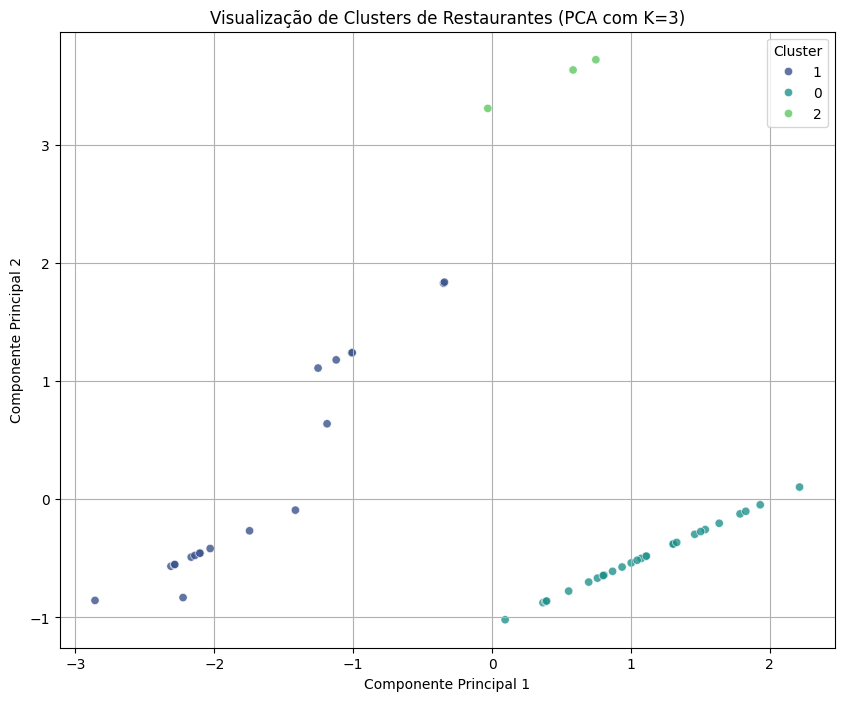

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

pca_df['Cluster'] = pca_df['Cluster'].astype('str')

sns.scatterplot(
    x='Principal_Componente_1',
    y='Principal_Componente_2',
    hue='Cluster',
    palette='viridis', 
    data=pca_df,
    legend='full',
    alpha=0.8
)

plt.title(f'Visualização de Clusters de Restaurantes (PCA com K={optimal_k})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

In [ ]:
import joblib
import os
from sklearn.preprocessing import StandardScaler 

model_directory = 'models'
os.makedirs(model_directory, exist_ok=True)

kmeans_filename = f'{model_directory}/kmeans_clusterizador_{optimal_k}_clusters.pkl'
joblib.dump(kmeans_final, kmeans_filename)

scaler_filename = f'{model_directory}/scaler_final.pkl'
joblib.dump(scaler, scaler_filename)

print(f"\n Modelo K-Means e o StandardScaler salvos na pasta 'models/'.")


 Modelo K-Means e o StandardScaler salvos na pasta 'models/'.
